In [1]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
from time import time
from os import getcwd

pd.set_option('notebook_repr_html', True, 'max_columns', 0)
%matplotlib inline

In [2]:
####### Understanding the project #######
# Our aim is to try and predict the outcome of an animal arriving at the animal shelter, 
# based on a few known features (Name, Age, Type etc...).
# The training set contains a large number of entries. Each entry (row) represnets an animal, 
# its known fetaures, and the outcome of the animal after it visited the shelter.

# We will try to use existing features in order to derive new features we believe will help predict the outcome, visualize the features
# and try to arrive at conclusions based on the visualizations.
# This process will help us understand the data, the problem and how to tackle them.

#We excluded the Datetime feature and the OutcomeSubType features 
# because this information is only available at the time of outcome and shouldn't be used to predict the outcome.

In [3]:
# load initial data
file = 'train.csv'
train_data = pd.read_csv(file)
train_data.head(10)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan
5,A677334,Elsa,2014-04-25 13:04:00,Transfer,Partner,Dog,Intact Female,1 month,Cairn Terrier/Chihuahua Shorthair,Black/Tan
6,A699218,Jimmy,2015-03-28 13:11:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Tabby
7,A701489,NaN,2015-04-30 17:02:00,Transfer,Partner,Cat,Unknown,3 weeks,Domestic Shorthair Mix,Brown Tabby
8,A671784,Lucy,2014-02-04 17:17:00,Adoption,NaN,Dog,Spayed Female,5 months,American Pit Bull Terrier Mix,Red/White
9,A677747,NaN,2014-05-03 07:48:00,Adoption,Offsite,Dog,Spayed Female,1 year,Cairn Terrier,White


In [4]:
# no animal IDs without A - we can remove the A and make it a number for better indexing
train_data[train_data['AnimalID'].str[:1] != 'A'] 

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color


In [5]:
train_data.OutcomeType.value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64

In [6]:
train_data.SexuponOutcome.value_counts()

Neutered Male    9779
Spayed Female    8820
Intact Male      3525
Intact Female    3511
Unknown          1093
Name: SexuponOutcome, dtype: int64

In [7]:
# Since 'Died' is a very small percentage of the outcome, we decided to remove it from the possible outcomes.
train_data = train_data[train_data.OutcomeType != 'Died']
# train_data = train_data[train_data.SexuponOutcome != 'Unknown']

# remove preceding 'A' and change AnimalID column to int
train_data['AnimalID'] = train_data['AnimalID'].str[1:]
train_data['AnimalID'] = train_data['AnimalID'].astype('int32')

# set AnimalID as index
train_data.set_index('AnimalID', inplace=True)

# change DateTime column to datetime
train_data['DateTime'] = pd.to_datetime(train_data['DateTime'])

In [8]:
train_data.describe()

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,18961,26532,26532,12936,26532,26531,26514,26532,26532
unique,6353,22739,4,11,2,5,44,1379,366
top,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,134,19,10769,7816,15545,9760,3956,8698,2797
first,NaN,2013-10-01 09:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2016-02-21 19:17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# looking at the datafrmae and the values in it, we decided to derive the following features out of it, because we believe they will be helpful in finding meaningful trends
train_data['HasName'] = (train_data.Name.str.len() > 0)

train_data[['Intact','Sex']] = train_data.SexuponOutcome.str.split(expand=True)
# train_data['Intact'] = train_data.Intact == 'Intact'
train_data['Intact'] = np.where(train_data.Intact.isin(['Spayed','Neutered']), False, train_data.Intact)
train_data['Intact'] = np.where(train_data.Intact == 'Intact', True, train_data.Intact)

train_data[['Breed1','Breed2','Breed3']] = train_data.Breed.str.split('/',expand=True)

train_data[['Color1','Color2']] = train_data.Color.str.split('/',expand=True)

train_data['Purebreed'] = ~(train_data.Breed1.str.contains('Mix')) & train_data.Breed2.isna()

train_data['SingleColor'] = train_data.Color2.isna()

#apply seems to wipe the describe data - not sure how to avoid this
train_data.head(10)

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,HasName,Intact,Sex,Breed1,Breed2,Breed3,Color1,Color2,Purebreed,SingleColor
AnimalID,,,,,,,,,,,,,,,,,,,
671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,True,False,Male,Shetland Sheepdog Mix,None,None,Brown,White,False,False
656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,True,False,Female,Domestic Shorthair Mix,None,None,Cream Tabby,None,False,True
686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,True,False,Male,Pit Bull Mix,None,None,Blue,White,False,False
683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,False,True,Male,Domestic Shorthair Mix,None,None,Blue Cream,None,False,True
667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,False,False,Male,Lhasa Apso,Miniature Poodle,None,Tan,None,False,True
677334,Elsa,2014-04-25 13:04:00,Transfer,Partner,Dog,Intact Female,1 month,Cairn Terrier/Chihuahua Shorthair,Black/Tan,True,True,Female,Cairn Terrier,Chihuahua Shorthair,None,Black,Tan,False,False
699218,Jimmy,2015-03-28 13:11:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Tabby,True,True,Male,Domestic Shorthair Mix,None,None,Blue Tabby,None,False,True
701489,NaN,2015-04-30 17:02:00,Transfer,Partner,Cat,Unknown,3 weeks,Domestic Shorthair Mix,Brown Tabby,False,Unknown,None,Domestic Shorthair Mix,None,None,Brown Tabby,None,False,True
671784,Lucy,2014-02-04 17:17:00,Adoption,NaN,Dog,Spayed Female,5 months,American Pit Bull Terrier Mix,Red/White,True,False,Female,American Pit Bull Terrier Mix,None,None,Red,White,False,False


In [10]:
train_data.describe()

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,HasName,Intact,Sex,Breed1,Breed2,Breed3,Color1,Color2,Purebreed,SingleColor
count,18961,26532,26532,12936,26532,26531,26514,26532,26532,26532,26531,25463,26532,3049,10,26532,13833,26532,26532
unique,6353,22739,4,11,2,5,44,1379,366,2,3,2,382,143,4,57,44,2,2
top,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White,True,False,Male,Domestic Shorthair Mix,Labrador Retriever,Tan Hound,Black,White,False,False
freq,134,19,10769,7816,15545,9760,3956,8698,2797,18961,18562,13206,8698,357,6,6371,8783,25149,13833
first,NaN,2013-10-01 09:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2016-02-21 19:17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# We want to convert the AgeuponOutcome column to a standard value in days
def ConvertDays(age):
    if age==None: return None
    if(' ' not in str(age)): return None
    value,unit = str(age).split()
    if 'year' in unit: return 365*int(value)
    if 'month' in unit: return 30*int(value)
    if 'week' in unit: return 7*int(value)
    if 'day' in unit:return int(value)
    return None

train_data['Age'] = train_data.AgeuponOutcome.apply(ConvertDays)


In [12]:
# Let's check if some animals visited the shelter more than once
print(train_data.index.nunique(), len(train_data))
# We can't tell if an animal visited more than once, since they seem to get a new AnimalID each visit.

26532 26532


In [13]:
#Now that we derived new features from the existing ones, let's try to visualize the data and understand the data better:
animal_type_xt = pd.crosstab(index=train_data.AnimalType,
                             columns=train_data.OutcomeType,
                             normalize='index'
                            )
animal_type_xt

OutcomeType,Adoption,Euthanasia,Return_to_owner,Transfer
AnimalType,,,,
Cat,0.388823,0.064622,0.045508,0.501047
Dog,0.417948,0.054358,0.275716,0.251978


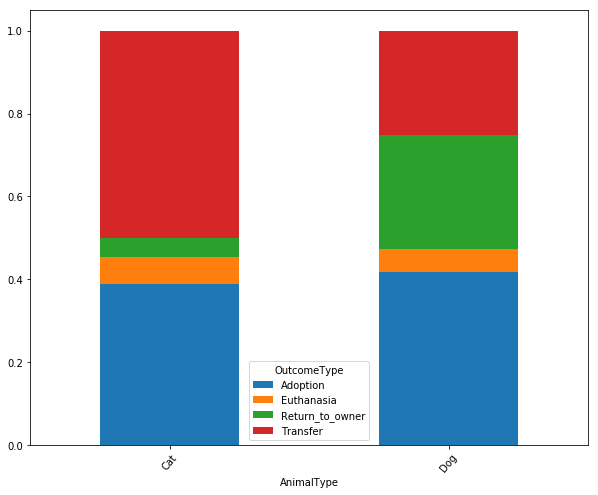

In [14]:
# we can see that there's a small chance of the pet being euthanised.
# however, dogs are much more likely to be returned to the owner than cats, which are more likely to be transferred.
animal_type_xt.plot.bar(stacked=True, figsize=(10,8), rot=50)

In [15]:
name_xt = pd.crosstab(index=[train_data.AnimalType,train_data.HasName],
                             columns=[train_data.OutcomeType],
                             normalize='index')
name_xt

OutcomeType         Adoption  Euthanasia  Return_to_owner  Transfer
AnimalType HasName                                                 
Cat        False    0.131114    0.112442         0.008930  0.747514
           True     0.598350    0.025743         0.075248  0.300660
Dog        False    0.390318    0.098714         0.041225  0.469743
           True     0.423611    0.045268         0.323773  0.207348

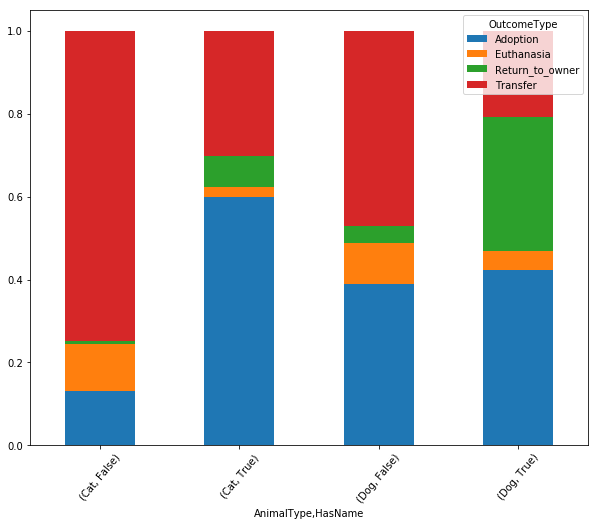

In [16]:
name_xt.plot.bar(stacked=True, figsize=(10,8), rot=50)
# we can see that both for cats and dogs having a name increases the chance of returning to owner.
# which makes sense as having a name seems to indicate a (previous) owner.
# It is also interesting to note that for cats, having a name increased adpotion rate significantly, while for dogs the adoption rate stays the same, but the chance of returning to owner increases.
# Are the animals more domesticated, healthier , or is it a psychological effect on potential adopters?
# It would be interesting to test if naming all animals produces better adoption results


In [17]:
intact_xt = pd.crosstab(index=[train_data.AnimalType,train_data.Intact],
                             columns=[train_data.OutcomeType],
                             normalize='index')
intact_xt

OutcomeType         Adoption  Euthanasia  Return_to_owner  Transfer
AnimalType Intact                                                  
Cat        False    0.666006    0.030213         0.076771  0.227010
           True     0.060452    0.110998         0.007112  0.821438
           Unknown  0.000000    0.090634         0.007049  0.902316
Dog        False    0.509716    0.031427         0.282287  0.176569
           True     0.041498    0.148785         0.253036  0.556680
           Unknown  0.000000    0.146667         0.066667  0.786667

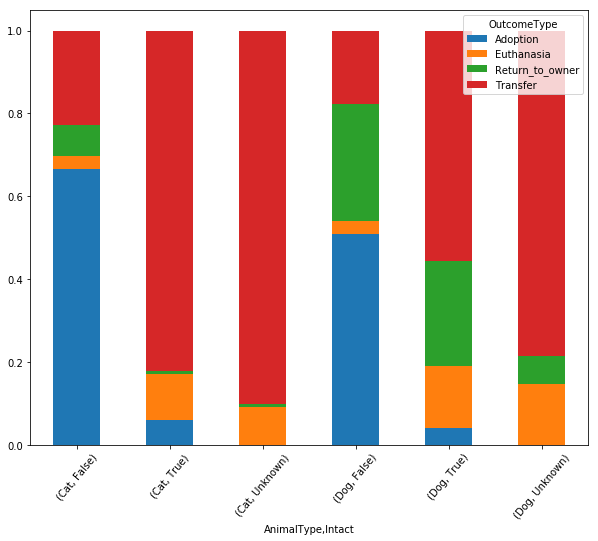

In [18]:
intact_xt.plot.bar(stacked=True, figsize=(10,8), rot=50)
# There is a very strong correlation between neutered/spayed animals and adoption.
# Possibly this indicates a preference for neutered animals.
# Alternatively the adoption is the cause and not the effect (if the neutering is part of the adoption process)

In [19]:
purebreed_xt = pd.crosstab(index=[train_data.AnimalType,train_data.Purebreed],
                             columns=[train_data.OutcomeType],
                             normalize='index')
purebreed_xt.head()


OutcomeType           Adoption  Euthanasia  Return_to_owner  Transfer
AnimalType Purebreed                                                 
Cat        False      0.387409    0.064817         0.045353  0.502421
           True       0.449799    0.056225         0.052209  0.441767
Dog        False      0.427868    0.055166         0.267782  0.249185
           True       0.291887    0.044092         0.376543  0.287478

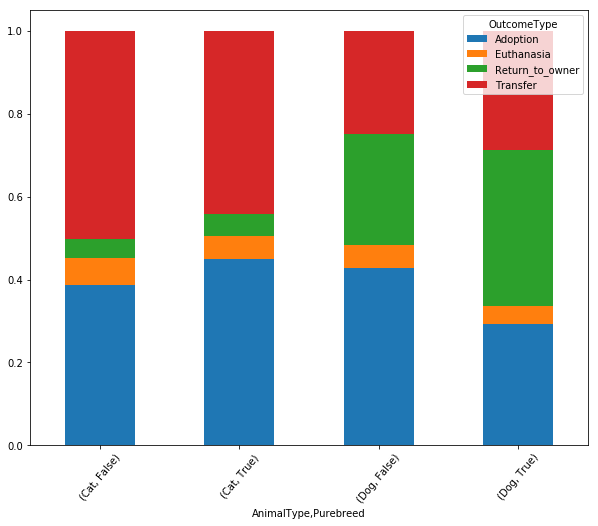

In [20]:
purebreed_xt.plot.bar(stacked=True, figsize=(10,8), rot=50)
#we see no significant correlation between outcome and pure vs. mixed breeds

In [21]:
# We will try and reduce the number of breed types to the most popular ones and try to find some correlation to the outcome:
d1 = train_data[['AnimalType','OutcomeType','Breed1']].copy()
d1['Breed'] = d1.Breed1
d1 = d1.drop('Breed1', axis = 1)

d2 = train_data[['AnimalType','OutcomeType','Breed2']].copy()
d2['Breed'] = d2.Breed2
d2 = d2.drop('Breed2', axis = 1)

d3 = train_data[['AnimalType','OutcomeType','Breed3']].copy()
d3['Breed'] = d3.Breed3
d3 = d3.drop('Breed3', axis = 1)
breed_data = d1.append(d2).append(d3)
cat_filtered_breed_data = breed_data[breed_data.AnimalType=='Cat']
cat_filtered_breed_data = cat_filtered_breed_data.groupby('Breed').filter(lambda x: len(x) >= 100)
filtered_breed_data = breed_data.groupby('Breed').filter(lambda x: len(x) >= 500)
filtered2_breed_data = breed_data.groupby('Breed').filter(lambda x: (len(x) >= 100) & (len(x)<500))
#print(d1.shape, d2.shape, d3.shape,breed_data.shape)
dog_filtered_breed_data = filtered_breed_data[filtered_breed_data.AnimalType=='Dog']
dog2_filtered_breed_data = filtered2_breed_data[filtered2_breed_data.AnimalType=='Dog']


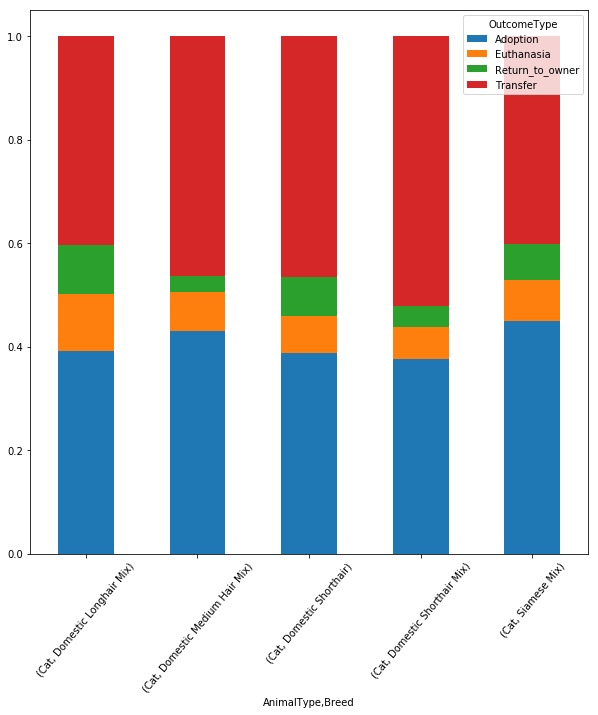

In [22]:
cat_breed_xt = pd.crosstab(index=[cat_filtered_breed_data.AnimalType,cat_filtered_breed_data.Breed],
                             columns=[cat_filtered_breed_data.OutcomeType],
                             normalize='index')
cat_breed_xt.plot.bar(stacked=True, figsize=(10,10),rot=50)
#we see no significant correlation between cat breed and outcome (breed with at least 100 sample size)

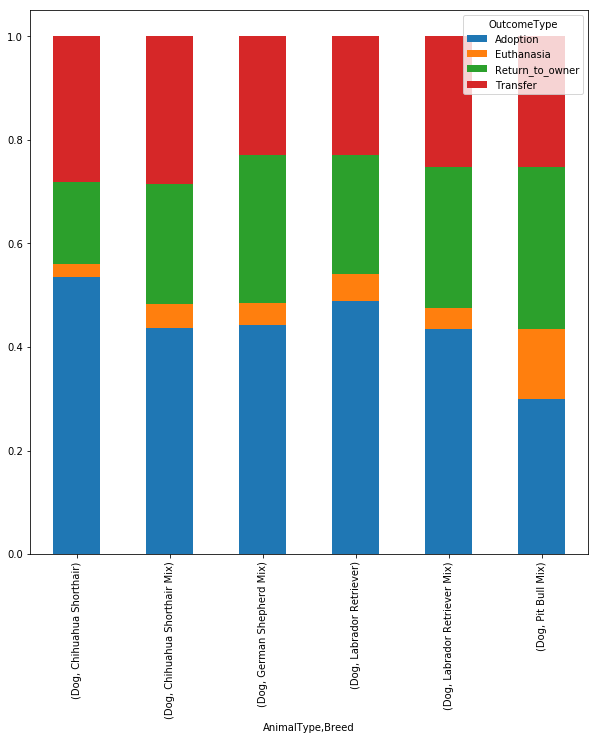

In [23]:
dog1_breed_xt = pd.crosstab(index=[dog_filtered_breed_data.AnimalType,dog_filtered_breed_data.Breed],
                             columns=[dog_filtered_breed_data.OutcomeType],
                             normalize='index')

dog1_breed_xt.plot.bar(stacked=True, figsize=(10,10))
#dog breed with at least 500 sample size

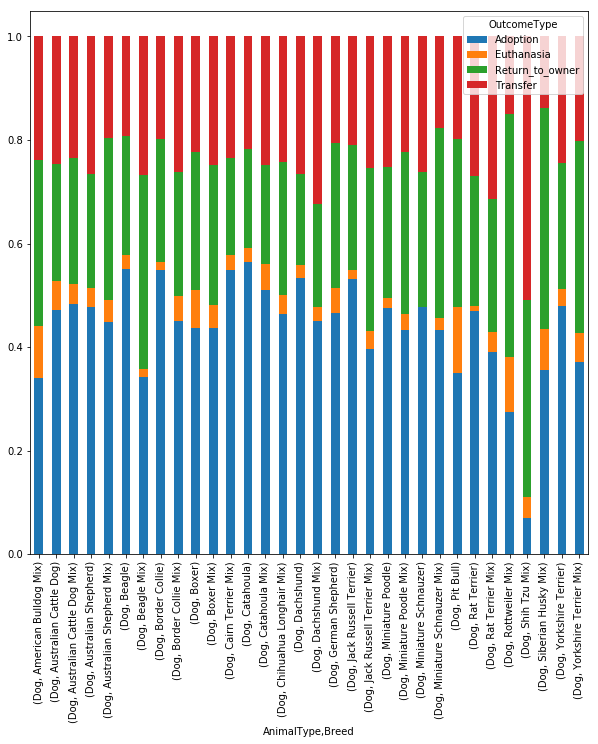

In [24]:
dog2_breed_xt = pd.crosstab(index=[dog2_filtered_breed_data.AnimalType,dog2_filtered_breed_data.Breed],
                             columns=[dog2_filtered_breed_data.OutcomeType],
                             normalize='index')

dog2_breed_xt.plot.bar(stacked=True, figsize=(10,10))
#dog breed with sample size 100 to 500
#overall there doesn't seem to be a strong correlation between breed and adoption although 
# Shih Tzu Mix breeds show particularly poor adoption rates, however this may be due to a small sample size.


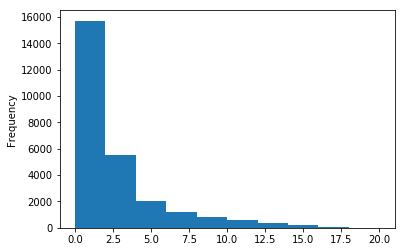

In [25]:
#Since AguponOutcome is hard to work with in its current form (years, months, weeks), and the age by days range is too big, we'll add a new feature of age by years
# bins = pd.IntervalIndex.from_tuples([(x-365, x) for x in range(365, 31*365, 365)])
# pd.cut(train_data.Age, bins)
train_data['AgeInYears'] = np.floor(train_data.Age / 365)

# we also want to add a broader categorical column of age:
bins = pd.IntervalIndex.from_tuples([(0, 1), (1 ,3), (3, 8), (8, 40)], closed='left')
train_data['AgeCategories'] = pd.cut(train_data.AgeInYears, bins)
train_data.AgeInYears.plot.hist()
# we can see a strong bias towards young animals in the data

In [26]:
age_xt = pd.crosstab(index=[train_data.AnimalType,train_data.AgeCategories],
                             columns=[train_data.OutcomeType],
                             normalize='index')
age_xt

OutcomeType               Adoption    ...     Transfer
AnimalType AgeCategories              ...             
Cat        [0, 1)         0.457735    ...     0.492127
           [1, 3)         0.200564    ...     0.643025
           [3, 8)         0.310181    ...     0.415794
           [8, 40)        0.372727    ...     0.218182
Dog        [0, 1)         0.537796    ...     0.346708
           [1, 3)         0.452990    ...     0.227305
           [3, 8)         0.316261    ...     0.205619
           [8, 40)        0.194654    ...     0.180946

[8 rows x 4 columns]

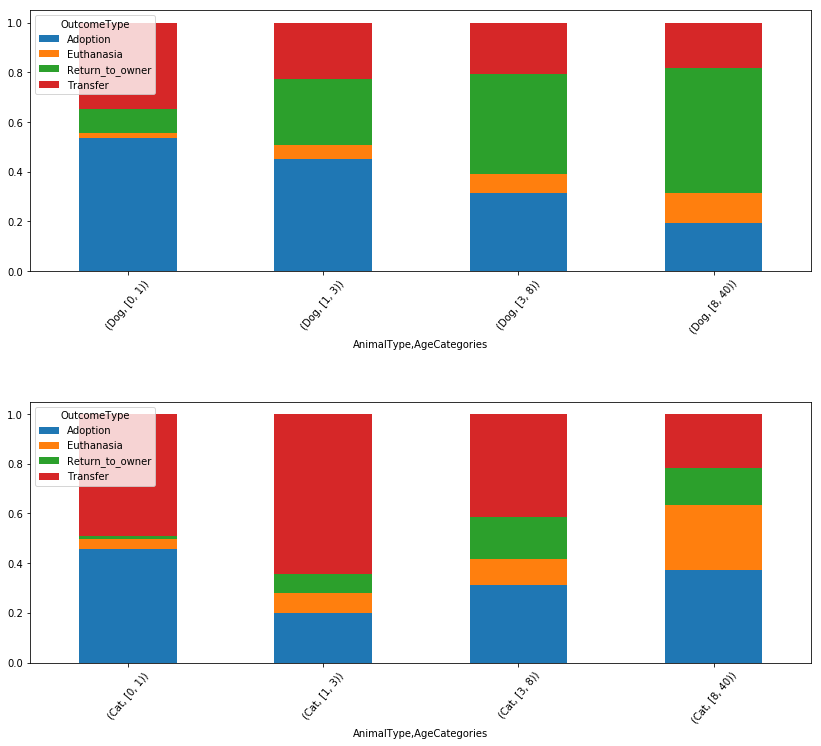

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=1)
plt.subplots_adjust(hspace=0.5)
age_xt.filter(like='Dog', axis=0).plot.bar(stacked=True, figsize=(14,12), rot=50, ax=axes[0], sharex=False)
age_xt.filter(like='Cat', axis=0).plot.bar(stacked=True, figsize=(14,12), rot=50, ax=axes[1], sharex=False)
# we can see that the probability of euthanasia increases with age, which is to be expected.
# in dogs we see that younger dogs get adopted, while older dogs get returned to their owners more.
# in cats the behavior is a bit less consistent.
# the "best" age for adoption seems to be 1-3 years old


In [28]:
sex_xt = pd.crosstab(index=[train_data.AnimalType,train_data.Sex],
                             columns=[train_data.OutcomeType],
                             normalize='index')

sex_xt

OutcomeType        Adoption  Euthanasia  Return_to_owner  Transfer
AnimalType Sex                                                    
Cat        Female  0.428374    0.055369         0.045517  0.470739
           Male    0.426509    0.068916         0.053263  0.451311
Dog        Female  0.447647    0.049011         0.253133  0.250209
           Male    0.396042    0.058163         0.297092  0.248703

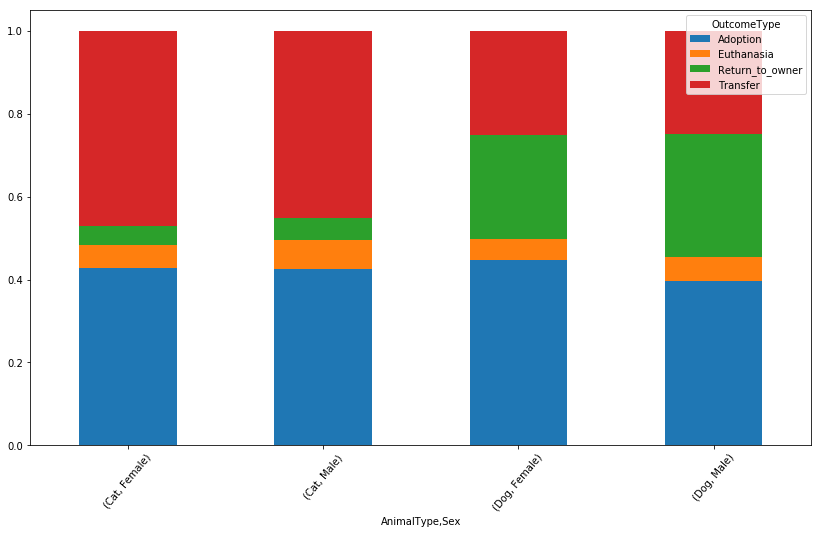

In [29]:
sex_xt.plot.bar(stacked=True, figsize=(14,8), rot=50)
# the sex of the animal doesn't seem to make a large difference in the outcome

In [30]:
single_color_xt = pd.crosstab(index=[train_data.AnimalType,train_data.SingleColor],
                             columns=[train_data.OutcomeType],
                             normalize='index')

single_color_xt

OutcomeType             Adoption  Euthanasia  Return_to_owner  Transfer
AnimalType SingleColor                                                 
Cat        False        0.396173    0.070339         0.050168  0.483320
           True         0.384831    0.061517         0.042978  0.510674
Dog        False        0.429862    0.056291         0.270419  0.243428
           True         0.396666    0.050905         0.285177  0.267252

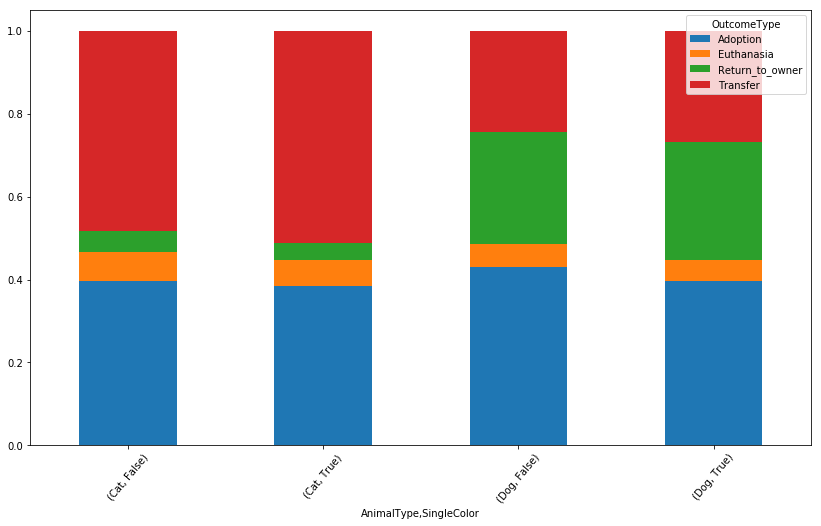

In [31]:
single_color_xt.plot.bar(stacked=True, figsize=(14,8), rot=50)
# color doesn't seem to make a difference as well

In [32]:
####### Conclusion ##########
# We managed to find some trends in the data, as well as find some biases (age of the animal for instance).
# In order to find more complex relationships we will need the help of machine learning.
# We believe we have derived enough good features out of the existing data to help create a good model for predicting the outcome.
# We intend to use the simpler features for the model:
# HasName, Intact, Sex, Purebreed, SingleColor, AgeCategories.
# We expect features that didn't show much significance in the manual analysis to not have much importance in the machine-learning model,
# however we don't want to remove them before testing this assumption, since there are always surprises and hidden relations.